In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import rampy as rp
import pandas as pd

import sklearn, h5py
from sklearn.externals import joblib

import sys
sys.path.append("/Users/charles/GoogleDrive/viscopy/")
sys.path.append("/Users/charles/GoogleDrive/structupy/")
sys.path.append("../")
import viscopy as vp
import neuravi

/Users/charles/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charles/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading dataset

Dataset has been prepared before

In [2]:
### Load dataset
f = h5py.File("../data/DataSet.hdf5", 'r')
# List all groups
X_columns = f['X_columns'].value

X_tv = f["X_tv"].value
X_tv_sc = f["X_tv_sc"].value
y_tv = f["y_tv"].value

X_train = f["X_train"].value
X_train_sc = f["X_train_sc"].value
y_train = f["y_train"].value

X_valid = f["X_valid"].value
X_valid_sc = f["X_valid_sc"].value
y_valid = f["y_valid"].value

X_test = f["X_test"].value
X_test_sc = f["X_test_sc"].value
y_test = f["y_test"].value

X_scaler_mean = f["X_scaler_mean"].value
X_scaler_var = f["X_scaler_var"].value

f.close()

print("loaded")
print("\nFeatures in X_ arrays are")
print(X_columns)
print("\nShape of X train and valid is")
print(X_tv.shape)

# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = X_train_sc[:,0:4] # 14 for all dataset, 4 for KNAS
cp_train = X_train_sc[:,(7,8)]
temperature_train = X_train_sc[:,9].reshape(-1,1)

#Be_train = X_train_sc[:,7].reshape(-1,1)
#Sc_train = X_train_sc[:,10].reshape(-1,1)

chimie_valid = X_valid_sc[:,0:4]
cp_valid = X_valid_sc[:,(7,8)]
temperature_valid = X_valid_sc[:,9].reshape(-1,1)

#Be_valid = X_valid_sc[:,7].reshape(-1,1)
#Sc_valid = X_valid_sc[:,10].reshape(-1,1)

chimie_test = X_test_sc[:,0:4]
cp_test = X_test_sc[:,(7,8)]
temperature_test = X_test_sc[:,9].reshape(-1,1)

loaded

Features in X_ arrays are
[b'sio2' b'al2o3' b'na2o' b'k2o' b'nbot' b'ifsm' b'ifst' b'ap' b'b' b'T'
 b'Sc' b'tg' b'ScT']

Shape of X train and valid is
(1145, 13)


In [45]:
name_in = "ReluD0p4_RMSP_3units_100it_10000"

figure_name = "KNAS_AG.pdf"

In [46]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        
        # make predictions
        train_pred_out = sess.run(pred, feed_dict={chimie_placeholder: chimie_train,
                                                   cp_a_placeholder: cp_train[:,0].reshape(-1,1),
                                                   cp_b_placeholder: cp_train[:,1].reshape(-1,1),
                                                     T_placeholder: temperature_train})
        
        valid_pred_out = sess.run(pred, feed_dict={chimie_placeholder: chimie_valid,
                                                   cp_a_placeholder: cp_valid[:,0].reshape(-1,1),
                                                   cp_b_placeholder: cp_valid[:,1].reshape(-1,1),
                                                     T_placeholder: temperature_valid})
        
        test_pred_out  = sess.run(pred, feed_dict={chimie_placeholder: chimie_test,
                                                   cp_a_placeholder: cp_test[:,0].reshape(-1,1),
                                                   cp_b_placeholder: cp_test[:,1].reshape(-1,1),
                                                     T_placeholder: temperature_test})
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/ReluD0p4_RMSP_3units_100it_10000/variables/variables
Ok
Predictions done


In [47]:
print("RMSE %.2f" %mean_squared_error(y_train, train_pred_out))

RMSE 0.28


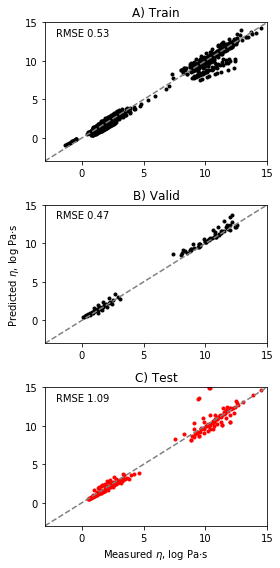

In [48]:
plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_train, train_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_valid, valid_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_test, test_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()

plt.savefig(figure_name)

# Quantification of RMSE

In [49]:
MSE_NN_train = np.sqrt(mean_squared_error(y_train, train_pred_out))
MSE_NN_valid = np.sqrt(mean_squared_error(y_valid, valid_pred_out))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, test_pred_out))

print("training, validation and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)
print(MSE_NN_test)

training, validation and testing RMSE with neural nets
0.5259821718481275
0.46916989727902714
1.091366732760183


# Calculating Ae

In [50]:
# KNAS, comment to deactivate
dataset = pd.read_excel("../data/Database_IPGP.xlsx",sheet_name="Sheet1").dropna()
dataset.head()

dataset = vp.chimie_control(dataset)
ap, b = vp.heatcp(dataset,dataset.tg)

dataset['ap'] = ap
dataset['b'] = b
dataset.head()

,Name,sio2,al2o3,fe2o3,h2o,na2o,k2o,mgo,cao,feo,...,color,Sc,tio2,li2o,bao,nio,mno,p2o5,ap,b
0,SiO2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,black,8.21,0.0,0.0,0.0,0.0,0.0,0.0,7.975338,0.0
1,SiO2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,black,8.21,0.0,0.0,0.0,0.0,0.0,0.0,7.975338,0.0
2,SiO2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,black,8.21,0.0,0.0,0.0,0.0,0.0,0.0,7.975338,0.0
3,SiO2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,black,8.21,0.0,0.0,0.0,0.0,0.0,0.0,7.975338,0.0
4,SiO2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,black,8.21,0.0,0.0,0.0,0.0,0.0,0.0,7.975338,0.0


# TECTOSILICATES

           Name  sio2  al2o3  fe2o3  h2o   na2o  k2o  mgo  cao  feo    ...     \
0          SiO2  1.00  0.000    0.0  0.0  0.000  0.0  0.0  0.0  0.0    ...      
392  NAK75_12_0  0.75  0.125    0.0  0.0  0.125  0.0  0.0  0.0  0.0    ...      
588  NAK50_25_0  0.50  0.250    0.0  0.0  0.250  0.0  0.0  0.0  0.0    ...      

       color    Sc  tio2 li2o  bao  nio  mno  p2o5         ap         b  
0      black  8.21   0.0  0.0  0.0  0.0  0.0   0.0   7.975338  0.000000  
392  magenta  9.20   0.0  0.0  0.0  0.0  0.0   0.0  -4.744034  0.011787  
588  magenta  4.85   0.0  0.0  0.0  0.0  0.0   0.0 -19.240402  0.023575  

[3 rows x 24 columns]

Restoring...
INFO:tensorflow:Restoring parameters from model/ReluD0p4_RMSP_3units_100it_10000/variables/variables
Ok
Predictions done


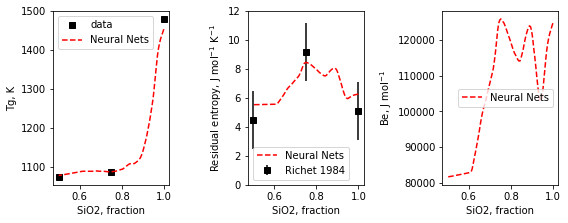

In [51]:
# only tectosilicate
na2otecto_subset = dataset[dataset.loc[:,"al2o3"] == dataset.loc[:,"na2o"]+dataset.loc[:,"k2o"]]
na2otecto_subset = na2otecto_subset[na2otecto_subset.loc[:,"k2o"]==0.0]
na2otecto_subset = na2otecto_subset.drop_duplicates(["tg"])
print(na2otecto_subset)

natecto_forplot = pd.DataFrame()

natecto_forplot["sio2"] = np.linspace(1.0,0.5,100)
natecto_forplot["al2o3"] = np.linspace(0.0,0.25,100)
natecto_forplot["na2o"]  = np.linspace(0.0,0.25,100)
natecto_forplot["k2o"] = np.zeros(100)
natecto_forplot["mgo"] = np.zeros(100)
natecto_forplot["cao"] = np.zeros(100)
natecto_forplot["Be"] = np.zeros(100)
natecto_forplot["Sc"] = np.zeros(100)
natecto_forplot["tg"] = np.zeros(100)
natecto_forplot["t"] = 1000.0*np.ones(100)

ap, b = vp.heatcp(natecto_forplot,1.0)

natecto_forplot["ap"] = ap
natecto_forplot["b"] = b

natecto_chimie = np.array([(natecto_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T
natecto_cp = natecto_forplot.loc[:,["ap","b"]].values
natecto_t = natecto_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), feed_dict={chimie_placeholder: natecto_chimie,
                                                   cp_a_placeholder: natecto_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: natecto_cp[:,1].reshape(-1,1),
                                                     T_placeholder: natecto_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))

plt.title("Na tectosilicates")
plt.subplot(1,3,1)

plt.plot(na2otecto_subset.sio2,na2otecto_subset.tg,"ks",label="data")
plt.plot(natecto_forplot["sio2"],Tg_tecto_pred,"r--",label="Neural Nets")

plt.xlabel("SiO2, fraction")
plt.ylabel("Tg, K")
plt.legend()

plt.subplot(1,3,2)
plt.plot(natecto_forplot["sio2"],S_tecto_pred,"r--",label="Neural Nets")
plt.errorbar([1.,0.75,0.5],[5.1,9.2,4.5],yerr=[2.,2.,2.],fmt="s",color="k",label="Richet 1984")

plt.ylim(0,12)
plt.xlabel("SiO2, fraction")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")
plt.legend(loc=3)

plt.subplot(1,3,3)
plt.plot(natecto_forplot["sio2"],Be_tecto_pred,"r--",label="Neural Nets")

plt.xlabel("SiO2, fraction")
plt.ylabel(r"Be, J mol$^{-1}$")
plt.legend()

plt.tight_layout()
plt.savefig("../figures/na_tecto.pdf")


Restoring...
INFO:tensorflow:Restoring parameters from model/ReluD0p4_RMSP_3units_100it_10000/variables/variables
Ok
Predictions done


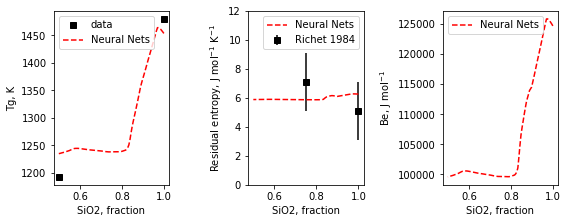

In [52]:
# only tectosilicate
k2otecto_subset = dataset[dataset.loc[:,"al2o3"] == dataset.loc[:,"na2o"]+dataset.loc[:,"k2o"]]
k2otecto_subset = k2otecto_subset[k2otecto_subset.loc[:,"na2o"]==0.0]
k2otecto_subset = k2otecto_subset.drop_duplicates(["tg"])
k2otecto_subset

#ktecto_chimie = k2otecto_subset.loc["sio2","al2o3","k2o","k2o"]
#ktecto_chimie = k2otecto_subset.loc["sio2","al2o3","k2o","k2o"]

ktecto_forplot = pd.DataFrame()

ktecto_forplot["sio2"] = np.linspace(1.0,0.5,100)
ktecto_forplot["al2o3"] = np.linspace(0.0,0.25,100)
ktecto_forplot["na2o"] = np.zeros(100)
ktecto_forplot["k2o"]  = np.linspace(0.0,0.25,100)
ktecto_forplot["mgo"] = np.zeros(100)
ktecto_forplot["cao"] = np.zeros(100)
ktecto_forplot["t"] = 1000.0*np.ones(100)

ap, b = vp.heatcp(ktecto_forplot,1.0)

ktecto_forplot["ap"] = ap
ktecto_forplot["b"] = b

ktecto_chimie = np.array([(ktecto_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T

ktecto_cp = ktecto_forplot.loc[:,["ap","b"]].values
ktecto_t = ktecto_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), feed_dict={chimie_placeholder: ktecto_chimie,
                                                   cp_a_placeholder: ktecto_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: ktecto_cp[:,1].reshape(-1,1),
                                                     T_placeholder: ktecto_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.title("K tectosilicates")

plt.subplot(1,3,1)

plt.plot(k2otecto_subset.sio2,k2otecto_subset.tg,"ks",label="data")
plt.plot(ktecto_forplot["sio2"],Tg_tecto_pred,"r--",label="Neural Nets")

plt.xlabel("SiO2, fraction")
plt.ylabel("Tg, K")
plt.legend()

plt.subplot(1,3,2)
plt.plot(ktecto_forplot["sio2"],S_tecto_pred,"r--",label="Neural Nets")
plt.errorbar([1.,0.75],[5.1,7.075],yerr=[2.,2.],fmt="s",color="k",label="Richet 1984")
plt.ylim(0,12)

plt.xlabel("SiO2, fraction")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")
plt.legend()

plt.subplot(1,3,3)
plt.plot(ktecto_forplot["sio2"],Be_tecto_pred,"r--",label="Neural Nets")

plt.xlabel("SiO2, fraction")
plt.ylabel(r"Be, J mol$^{-1}$")
plt.legend()

plt.tight_layout()

plt.savefig("../figures/k_tecto.pdf")

# SILICATES


Restoring...
INFO:tensorflow:Restoring parameters from model/ReluD0p4_RMSP_3units_100it_10000/variables/variables
Ok
Predictions done


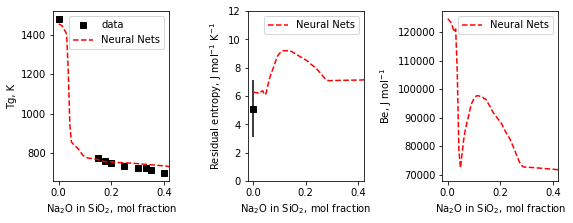

In [53]:
# only tectosilicate
nasilicates_subset = dataset[(dataset.loc[:,"al2o3"] == 0.0)&(dataset.loc[:,"k2o"] == 0.0)]
#nasilicates_subset = nasilicates_subset[nasilicates_subset.loc[:,"k2o"] == 0.0]
nasilicates_subset = nasilicates_subset.drop_duplicates(["tg"])

nasilicates_forplot = pd.DataFrame()

nasilicates_forplot["sio2"] = np.linspace(1.0,0.6,100)
nasilicates_forplot["al2o3"] = np.zeros(100)
nasilicates_forplot["na2o"]  = np.linspace(0.0,0.6,100)
nasilicates_forplot["k2o"] = np.zeros(100)
nasilicates_forplot["mgo"] = np.zeros(100)
nasilicates_forplot["cao"] = np.zeros(100)
nasilicates_forplot["t"] = 1000.0*np.ones(100)

ap, b = vp.heatcp(nasilicates_forplot,1.0)

nasilicates_forplot["ap"] = ap
nasilicates_forplot["b"] = b

nasilli_chimie = np.array([(nasilicates_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T

nasilli_cp = nasilicates_forplot.loc[:,["ap","b"]].values
nasilli_t = nasilicates_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: nasilli_chimie,
                                                   cp_a_placeholder: nasilli_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nasilli_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nasilli_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.title(r"Na$_2$O-SiO$_2$ join")
plt.subplot(1,3,1)

plt.plot(nasilicates_subset.na2o,nasilicates_subset.tg,"ks",label="data")
plt.plot(nasilicates_forplot["na2o"],Tg_tecto_pred,"r--",label="Neural Nets")
plt.xlim(-0.02,0.42)

plt.legend()
plt.xlabel(r"Na$_2$O in SiO$_2$, mol fraction")
plt.ylabel("Tg, K")

plt.subplot(1,3,2)
plt.plot(nasilicates_forplot["na2o"],S_tecto_pred,"r--",label="Neural Nets")
plt.errorbar([0.],[5.1],yerr=[2.],fmt="s",color="k")
plt.xlim(-0.02,0.42)
plt.ylim(0,12)

plt.legend()
plt.xlabel(r"Na$_2$O in SiO$_2$, mol fraction")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")

plt.subplot(1,3,3)
plt.plot(nasilicates_forplot["na2o"],Be_tecto_pred,"r--",label="Neural Nets")
plt.xlim(-0.02,0.42)

plt.legend()
plt.xlabel(r"Na$_2$O in SiO$_2$, mol fraction")
plt.ylabel(r"Be, J mol$^{-1}$")

plt.tight_layout()

plt.savefig("../figures/na2osio2.pdf")

# Na-K mixing

         Name   sio2  al2o3  fe2o3  h2o   na2o    k2o  mgo  cao  feo  \
79       NS75  0.750    0.0    0.0  0.0  0.250  0.000  0.0  0.0  0.0   
232      KS75  0.750    0.0    0.0  0.0  0.000  0.250  0.0  0.0  0.0   
291  NKS75_11  0.758    0.0    0.0  0.0  0.129  0.113  0.0  0.0  0.0   
297  NKS75_16  0.768    0.0    0.0  0.0  0.066  0.166  0.0  0.0  0.0   

       ...      color         Sc  tio2 li2o  bao  nio  mno  p2o5         ap  \
79     ...       blue   8.637469   0.0  0.0  0.0  0.0  0.0   0.0  14.214681   
232    ...     purple  10.779168   0.0  0.0  0.0  0.0  0.0   0.0   9.999513   
291    ...        red  13.032986   0.0  0.0  0.0  0.0  0.0   0.0  11.440241   
297    ...        red  13.227128   0.0  0.0  0.0  0.0  0.0   0.0  10.479278   

            b  
79   0.000000  
232  0.003945  
291  0.001783  
297  0.002619  

[4 rows x 24 columns]

Restoring...
INFO:tensorflow:Restoring parameters from model/ReluD0p4_RMSP_3units_100it_10000/variables/variables
Ok
Predictions done


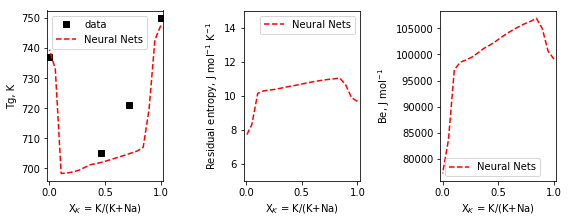

In [54]:
nak_subset = dataset.loc[(dataset.loc[:,"sio2"] > 0.73)&
                         (dataset.loc[:,"sio2"] < 0.77)&
                         (dataset.loc[:,"al2o3"]==0.00) 
                         #(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.75*np.ones(20)
nak_forplot["al2o3"] = 0.0*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.25,20)
nak_forplot["k2o"] = 0.25-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = np.array([(nak_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T

#nak_chimie = nak_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.title("Na-K mixing in trisilicates")
plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks",label="data")
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--",label="Neural Nets")

plt.legend()
plt.xlim(-0.02,1.02)

plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel("Tg, K")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--",label="Neural Nets")
#plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
plt.xlim(-0.02,1.02)
plt.ylim(5,15)
plt.legend()

plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--",label="Neural Nets")
plt.xlim(-0.02,1.02)
plt.legend()

plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel("Be, J mol$^{-1}$")

plt.tight_layout()
plt.savefig("../figures/nak_trisili.pdf")

         Name   sio2  al2o3  fe2o3  h2o   na2o    k2o  mgo  cao  feo  \
120      NS66  0.667    0.0    0.0  0.0  0.333  0.000  0.0  0.0  0.0   
263      KS66  0.660    0.0    0.0  0.0  0.000  0.340  0.0  0.0  0.0   
321  NKS66_31  0.661    0.0    0.0  0.0  0.311  0.028  0.0  0.0  0.0   
327  NKS67_26  0.672    0.0    0.0  0.0  0.263  0.065  0.0  0.0  0.0   
333  NKS66_17  0.668    0.0    0.0  0.0  0.178  0.154  0.0  0.0  0.0   

       ...      color         Sc  tio2 li2o  bao  nio  mno  p2o5         ap  \
120    ...       blue   6.069337   0.0  0.0  0.0  0.0  0.0   0.0  14.152132   
263    ...     purple   8.895475   0.0  0.0  0.0  0.0  0.0   0.0  10.627208   
321    ...        red   8.223513   0.0  0.0  0.0  0.0  0.0   0.0  14.159526   
327    ...        red   9.935090   0.0  0.0  0.0  0.0  0.0   0.0  13.298526   
333    ...        red  11.965691   0.0  0.0  0.0  0.0  0.0   0.0  11.136875   

            b  
120  0.000000  
263  0.005365  
321  0.000442  
327  0.001026  
333  0.00243

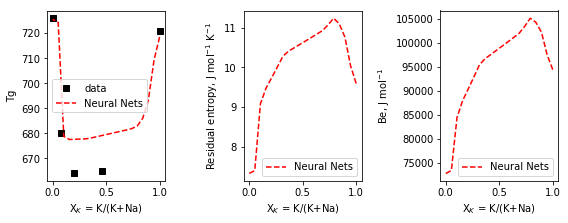

In [55]:
nak_subset = dataset.loc[(dataset.loc[:,"sio2"] > 0.65)&
                         (dataset.loc[:,"sio2"] < 0.69)&
                         (dataset.loc[:,"al2o3"]==0.00) 
                         #(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.666*np.ones(20)
nak_forplot["al2o3"] = 0.0*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.333,20)
nak_forplot["k2o"] = 0.333-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = np.array([(nak_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.title("Na-K mixing in disilicates")
plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks",label="data")
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--",label="Neural Nets")
#plt.xlim(1,0.6)

plt.legend()
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--",label="Neural Nets")
#plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
#plt.xlim(1,0.6)

plt.legend()
#plt.ylim(0,12)
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--",label="Neural Nets")
#plt.xlim(1,0.6)

plt.legend()
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel(r"Be, J mol$^{-1}$")

plt.tight_layout()
plt.savefig("../figures/nak_disili.pdf")

            Name    sio2   al2o3  fe2o3  h2o    na2o     k2o  mgo  cao  feo  \
392   NAK75_12_0  0.7500  0.1250    0.0  0.0  0.1250  0.0000  0.0  0.0  0.0   
434   NAK75_12_2  0.7537  0.1251    0.0  0.0  0.0975  0.0237  0.0  0.0  0.0   
453   NAK75_12_4  0.7533  0.1244    0.0  0.0  0.0744  0.0479  0.0  0.0  0.0   
470   NAK75_12_6  0.7516  0.1250    0.0  0.0  0.0619  0.0615  0.0  0.0  0.0   
487   NAK75_12_7  0.7553  0.1230    0.0  0.0  0.0501  0.0715  0.0  0.0  0.0   
501  NAK75_12_10  0.7515  0.1243    0.0  0.0  0.0266  0.0976  0.0  0.0  0.0   
514  NAK75_12_12  0.7506  0.1275    0.0  0.0  0.0009  0.1210  0.0  0.0  0.0   
817      NA75_15  0.7500  0.1500    0.0  0.0  0.1000  0.0000  0.0  0.0  0.0   
840      NA75_16  0.7500  0.1600    0.0  0.0  0.0900  0.0000  0.0  0.0  0.0   

       ...       color    Sc  tio2 li2o  bao  nio  mno  p2o5        ap  \
392    ...     magenta  9.20   0.0  0.0  0.0  0.0  0.0   0.0 -4.744034   
434    ...     magenta  9.06   0.0  0.0  0.0  0.0  0.0   0.0 

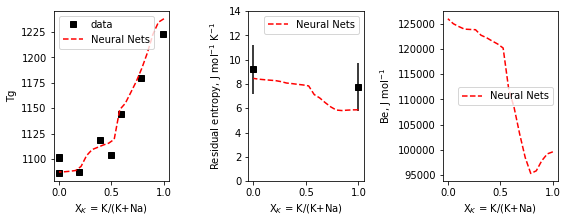

In [56]:
nak_subset = dataset.loc[#(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]==0.00) 
                         (dataset.loc[:,"sio2"] > 0.73)&
                         (dataset.loc[:,"sio2"] < 0.77)&
                         (dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.75*np.ones(20)
nak_forplot["al2o3"] = 0.125*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.125,20)
nak_forplot["k2o"] = 0.125-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = np.array([(nak_forplot.iloc[:,i]-X_scaler_mean[i])/np.sqrt(X_scaler_var[i]) for i in range(4)]).T
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.title("Albite-Orthoclase mixing")

plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks",label="data")
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--",label="Neural Nets")
#plt.xlim(1,0.6)

plt.legend()
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--",label="Neural Nets")
plt.errorbar([0.,1.0],[9.2,7.75],yerr=[2.,2.],fmt="s",color="k")
#plt.xlim(1,0.6)

plt.legend()
plt.ylim(0,14)
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel(r"Residual entropy, J mol$^{-1}$ K$^{-1}$")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--",label="Neural Nets")
#plt.xlim(1,0.6)

plt.legend()
plt.xlabel(r"X$_K$ = K/(K+Na)")
plt.ylabel(r"Be, J mol$^{-1}$")

plt.tight_layout()
plt.savefig("../figures/nak_AbOr.pdf")

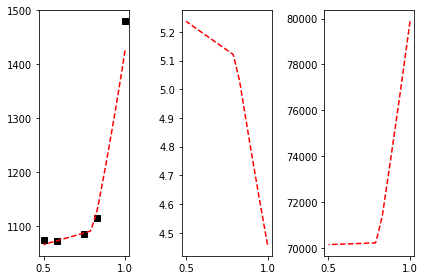

In [38]:

ap, b = vp.heatcp(nasilicates_forplot,1.0)

nasilicates_forplot["ap"] = ap
nasilicates_forplot["b"] = b

nasilli_chimie = nasilicates_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nasilli_cp = nasilicates_forplot.loc[:,["ap","b"]].values
nasilli_t = nasilicates_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: nasilli_chimie,
                                                   cp_a_placeholder: nasilli_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nasilli_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nasilli_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nasilicates_subset.sio2,nasilicates_subset.tg,"ks")
plt.plot(nasilicates_forplot["sio2"],Tg_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nasilicates_forplot["sio2"],S_tecto_pred,"r--")
plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nasilicates_forplot["sio2"],Be_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

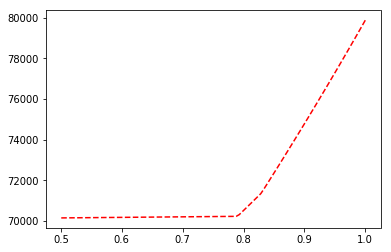

In [36]:
#plt.plot(na2otecto_subset.sio2,na2otecto_subset.tg,"ks")


In [64]:
import pandas as pd
#
dataset_post = pd.read_csv("./data/rhyolite_for_post_analysis.csv")

to_pred_c= dataset_post.loc[:,"sio2":"h2o"].values
to_pred_c = to_pred_c/to_pred_c.sum(axis=1).reshape(-1,1)
print("Chemistry array loaded:")
print(to_pred_c)

to_pred_T= dataset_post.loc[:,"T"]
print("Temperature DataFrame loaded:")
print(to_pred_T.head())

to_pred_n= dataset_post.loc[:,"viscosity"]
print("Viscosity DataFrame loaded:")
print(to_pred_n.head())

Chemistry array loaded:
[[0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         

In [65]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        
        # Get prediction tensors
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        a_ = restored_graph.get_tensor_by_name('A:0')
        b_ = restored_graph.get_tensor_by_name('B:0')
        t1_ = restored_graph.get_tensor_by_name('T1:0')
        
        # make predictions
        visco_p,a_p,b_p,t1_p  = sess.run([pred,a_,b_,t1_], 
                                          feed_dict={chimie_placeholder: to_pred_c, 
                                                     T_placeholder: to_pred_T.values.reshape(-1,1)})
        
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/TVF_layer_1units_100it_100/variables/variables
Ok
Predictions done


In [66]:
dataset_post

,Name,sio2,tio2,al2o3,feot,mno,bao,sro,mgo,cao,li2o,na2o,k2o,p2o5,h2o,T,viscosity,ScTg,Tg,Source
0,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1112.4,12.05,Le Losq and Neuville 2013,NaN,NaN
1,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1132.8,11.61,Le Losq and Neuville 2013,NaN,NaN
2,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1148.4,11.31,Le Losq and Neuville 2013,NaN,NaN
3,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1170.5,10.98,Le Losq and Neuville 2013,NaN,NaN
4,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1185.0,10.65,Le Losq and Neuville 2013,NaN,NaN
5,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1190.3,10.58,Le Losq and Neuville 2013,NaN,NaN
6,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1201.7,10.38,Le Losq and Neuville 2013,NaN,NaN
7,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1209.5,10.22,Le Losq and Neuville 2013,NaN,NaN
8,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1211.5,10.21,Le Losq and Neuville 2013,NaN,NaN
9,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1227.4,9.91,Le Losq and Neuville 2013,NaN,NaN


ValueError: x and y must be the same size

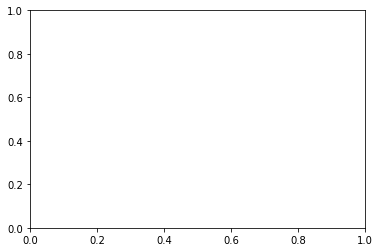

In [67]:
plt.scatter(to_pred_n,visco_p[0],c=dataset_post.k2o)
plt.colorbar()
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Viscosity")
print(np.sqrt(mean_squared_error(visco_p[0], to_pred_n)))

In [48]:
visco_p

[array([[11.837589 ],
        [11.428139 ],
        [11.127399 ],
        [10.718559 ],
        [10.460672 ],
        [10.368368 ],
        [10.173265 ],
        [10.04241  ],
        [10.009193 ],
        [ 9.749905 ],
        [ 9.756327 ],
        [ 9.261556 ],
        [ 9.362604 ],
        [ 9.689213 ],
        [ 9.931807 ],
        [10.240166 ],
        [10.455952 ],
        [10.746614 ],
        [11.1217785],
        [11.466278 ],
        [11.744598 ],
        [ 9.761924 ],
        [ 9.931669 ],
        [10.1511965],
        [10.271924 ],
        [10.515288 ],
        [10.5727625],
        [10.935584 ],
        [11.224608 ],
        [11.3817625],
        [11.713056 ],
        [11.860425 ],
        [12.188645 ],
        [10.307516 ],
        [10.472628 ],
        [10.600956 ],
        [10.80192  ],
        [11.004    ],
        [11.281811 ],
        [11.624159 ],
        [10.854235 ],
        [10.989639 ],
        [11.057198 ],
        [11.117491 ],
        [11.191982 ],
        [1

Text(0.5,1,'Measured vs Predicted Entropy')

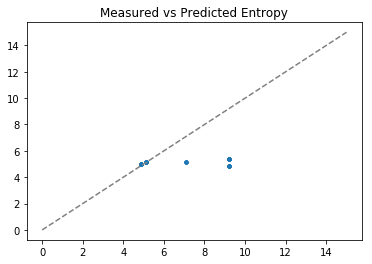

In [19]:
plt.plot(dataset_post.loc[:,"ScTg"],sctg_p,".")
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Entropy")

Text(0.5,1,'Measured vs Predicted Glass Transition Temperature')

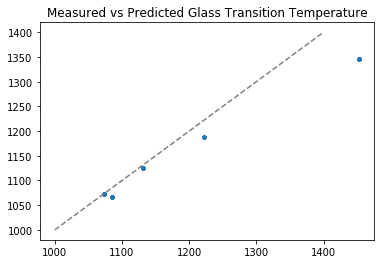

In [20]:
plt.plot(dataset_post.loc[:,"Tg"],tg_p,".")
plt.plot([1000,1400],[1000,1400],"--",color="grey")
plt.title("Measured vs Predicted Glass Transition Temperature")

# Continue Training

In [35]:
NEPOCH = 1000
loss_train = np.zeros(NEPOCH)
loss_valid = np.zeros(NEPOCH)

from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        n_placeholder = restored_graph.get_tensor_by_name('viscosity:0')
        
        # Get loss
        opt = restored_graph.get_collection('optimizer')
        loss = restored_graph.get_tensor_by_name('loss:0')
        
        for i in range(NEPOCH):
        
            # train
            sess.run(opt,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            # calculate loss
            loss_train[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            loss_valid[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_valid, 
                                 T_placeholder: temperature_valid.reshape(-1,1),
                                 n_placeholder: d.y_valid.reshape(-1,1)})
        
            if (i % 500 == 0):
                print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
        print('Training done')


Restoring...
INFO:tensorflow:Restoring parameters from model/layer1units200it10000/variables/variables
Ok


ValueError: could not convert string to float: b'\n\x0b\n\x04loss\x15\xa5%TD'

In [ ]:
tf.nn.l2_loss()